In [150]:
import pandas as pd
import numpy as np
import re
import random
import opendatasets as od

import torch
import torchtext
import torch.nn as nn

import torch.nn.functional as F
from torch.optim import Adam

from torchtext.data import Field,LabelField,TabularDataset,BucketIterator
from torchtext.vocab import Vocab
from torchtext.vocab import GloVe

from modules.LSTMBi import RNN_LSTM



In [151]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
print(device)
print(torch.__version__)
print(torchtext.__version__)

cuda
1.11.0+cu113
0.6.0


In [152]:
#od.download('https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset')

### Importing Dataset

In [153]:
real_df = pd.read_csv('D:/py-py-py-pytorch/rnn/fake-and-real-news-dataset/True.csv')
fake_df = pd.read_csv('D:/py-py-py-pytorch/rnn/fake-and-real-news-dataset/Fake.csv')

In [154]:
real_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [155]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


### Preprocessing and Merging

In [156]:
real_df.drop(['date','subject'],axis=1,inplace=True)
fake_df.drop(['date','subject'],axis=1,inplace=True)

In [157]:
real_df['Label'] = 1.0
fake_df['Label'] = 0.0

In [158]:
real_df['TEXT'] = real_df['title']+real_df['text']
real_df.drop(['title','text'],axis=1,inplace=True)

In [159]:
fake_df['TEXT'] = fake_df['title']+fake_df['text']
fake_df.drop(['title','text'],axis=1,inplace=True)

In [160]:
real_df.head(3)

,Label,TEXT
0,1.0,"As U.S. budget fight looms, Republicans flip t..."
1,1.0,U.S. military to accept transgender recruits o...
2,1.0,Senior U.S. Republican senator: 'Let Mr. Muell...


In [161]:
fake_df.head(3)

,Label,TEXT
0,0.0,Donald Trump Sends Out Embarrassing New Year’...
1,0.0,Drunk Bragging Trump Staffer Started Russian ...
2,0.0,Sheriff David Clarke Becomes An Internet Joke...


In [162]:
news_df = pd.concat([fake_df,real_df],ignore_index=True)
news_df

,Label,TEXT
0,0.0,Donald Trump Sends Out Embarrassing New Year’...
1,0.0,Drunk Bragging Trump Staffer Started Russian ...
2,0.0,Sheriff David Clarke Becomes An Internet Joke...
3,0.0,Trump Is So Obsessed He Even Has Obama’s Name...
4,0.0,Pope Francis Just Called Out Donald Trump Dur...
...,...,...
44893,1.0,'Fully committed' NATO backs new U.S. approach...
44894,1.0,LexisNexis withdrew two products from Chinese ...
44895,1.0,Minsk cultural hub becomes haven from authorit...
44896,1.0,Vatican upbeat on possibility of Pope Francis ...


In [163]:
news_df.rename(columns={'Label':'LABEL'},inplace=True)

In [164]:
#news_df.to_csv('news_data.csv')

### NLP Tasks

In [165]:
news_df['TEXT'] = news_df['TEXT'].apply(lambda x:x.lower())
news_df['TEXT'] = news_df['TEXT'].apply(lambda x:re.sub('[^a-zA-z0-9\s]','',x))

In [166]:
TEXT = Field(sequential=True,tokenize='spacy',tokenizer_language='en_core_web_sm',lower=True,fix_length=100)
LABEL = LabelField(dtype=torch.float32)
Fields =[(None, None),('LABEL',LABEL),('TEXT',TEXT)]

In [167]:
news_ds = TabularDataset(
    path='D:/py-py-py-pytorch/rnn/news_data.csv', format='csv',
    skip_header=True, fields=Fields)

In [168]:
len(news_ds)

44898

In [169]:
train_data, test_data = news_ds.split(
    split_ratio=[0.9, 0.1],
    random_state=random.seed(47))

print(f'Num Train: {len(train_data)}')
print(f'Num Test: {len(test_data)}')

Num Train: 40408
Num Test: 4490


In [170]:
train_data, valid_data = train_data.split(
    split_ratio=[0.81, 0.19],
    random_state=random.seed(47))

print(f'Num Train: {len(train_data)}')
print(f'Num Validation: {len(valid_data)}')

Num Train: 32730
Num Validation: 7678


In [171]:
print(vars(train_data.examples[0]))

{'LABEL': '0', 'TEXT': ['sickening', 'reason', 'cophating', 'racist', '49ers', 'qb', 'colin', 'kaepernick', 'just', 'announced', 'hell', 'now', 'stand', 'for', 'national', 'anthemit', 'looks', 'like', 'veteran', 'san', 'francisco', '49ers', 'quarterback', 'colin', 'kaepernick', 'might', 'be', 'done', 'with', 'his', 'national', 'anthem', 'protests', '  ', 'now', 'that', 'he', 's', 'looking', 'for', 'a', 'new', 'nfl', 'contractthe', 'controversial', 'player', 'will', 'stand', 'for', ' ', 'the', 'starspangled', 'banner', ' ', 'next', 'season', 'according', 'to', 'sources', 'who', 'spoke', 'to', 'espn', 'thursday', 'kaepernick', 'first', 'made', 'headlines', 'in', 'august', '2016', 'for', 'refusing', 'to', 'stand', 'during', 'his', 'team', 's', 'preseason', 'game', 'against', 'the', 'green', 'bay', 'packers', 'citing', 'the', ' ', 'oppression', ' ', 'of', 'black', 'people', 'in', 'the', 'united', 'stateskaepernick', 'explained', 'his', 'refusal', 'to', 'stand', 'for', 'the', 'starspangled'

In [172]:
TEXT.build_vocab(train_data,vectors="glove.6B.100d",min_freq=5)
LABEL.build_vocab(train_data)

print("Vocabualry Size is %d" % len(TEXT.vocab))

Vocabualry Size is 46287


In [173]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 735297), ('to', 400454), ('of', 325812), ('a', 299194), ('and', 297588), (' ', 272353), ('in', 256847), ('that', 173477), ('on', 142756), ('s', 130284), ('for', 130088), ('is', 122939), ('he', 96952), ('said', 94590), ('trump', 92232), ('it', 90707), ('with', 87997), ('was', 84886), ('as', 75895), ('his', 71217)]


In [174]:
vocab_dict = TEXT.vocab.stoi

In [175]:
train_dl,valid_dl,test_dl = BucketIterator.splits((train_data,valid_data,test_data),
                                           batch_size=32,
                                           sort_within_batch=False,
                                           sort_key=lambda x: len(x.TEXT),device=device)

### Create Embedding GloVe

In [176]:
# import gensim.downloader as api
# loaded_glove_model = api.load("glove-wiki-gigaword-300")
# loaded_glove_embeddings = loaded_glove_model.vectors

In [177]:
# from modules.GloveEmbeddings import create_custom_glove_embedding

In [178]:
# Glove_embeddings = create_custom_glove_embedding(TEXT.vocab,300)

In [179]:
# type(Glove_embeddings)

In [180]:
# Glove_embeddings.shape

### RNN-LSTM Model Building

In [181]:
# class RNN_LSTM(nn.Module):
#     '''
#     Building an RNN_LSTM model 
#     '''
#     def __init__(self,input_dim,embedding_dim,hidden_dim,output_dim,num_layers):
#         super().__init__()
#         self.num_layers = num_layers
#         self.input_dim = input_dim
#         self.embedding_dim = embedding_dim
#         self.hidden_dim = hidden_dim
#         self.output_dim = output_dim

#         #Embedding 
#         self.embedding_layer = nn.Embedding.from_pretrained(embeddings=torch.FloatTensor(Glove_embeddings),freeze= False)
        
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,batch_first = True)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#         # self.softmax = nn.Softmax(dim=1)
    
#     def forward(self,x):
#         embed = self.embedding_layer(x)

#         out,(hidden,_) = self.lstm(embed)

#         flattened = hidden[-1]

#         out = torch.squeeze(self.fc(flattened))
        
#         return out


In [182]:
pre_trained_embedded_weight_val = TEXT.vocab.vectors

In [183]:
model = RNN_LSTM(input_dim=len(TEXT.vocab),
                 num_layers=3,
                 embedding_dim=100,
                 hidden_dim=256,
                 output_dim=1,
                 pre_trained_embed_weights=pre_trained_embedded_weight_val,
                 )


model = model.to(device)


In [184]:
print(model)

RNN_LSTM(
  (embedding_layer): Embedding(46287, 100)
  (lstm): LSTM(100, 256, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)


In [185]:
model.parameters

<bound method Module.parameters of RNN_LSTM(
  (embedding_layer): Embedding(46287, 100)
  (lstm): LSTM(100, 256, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)>

In [186]:
# # Embedding matrix shape
# it = iter(model.parameters())
# next(it)[0].shape

### Training and Evaluation

In [187]:
# torch.cuda.get_device_properties(0).name

In [188]:
num_epochs = 3
optimizer = Adam(model.parameters(),lr=0.0025)
loss_fn = nn.BCEWithLogitsLoss()

In [189]:
model = model.to(device)

### Training_loop_1

In [190]:
# for epoch in range(num_epochs):
#     train_acc = 0.0
#     valid_acc = 0.0
#     train_pred, train_orig, valid_pred, valid_orig = [], [], [], []

#     for i, batch_data in enumerate(train_dl):
#         text = batch_data.TEXT.to(device)
#         labels = batch_data.LABEL.type(torch.LongTensor)
#         labels = labels.to(device)   
#         text = text.permute(1,0)
#         #forward
#         preds,_ = model.forward(text)
#         # print(preds.shape)
#         # print(labels.shape)
#         #loss
#         loss = loss_fn(preds,labels)
#         #backprop
#         optimizer.zero_grad()
#         loss.backward()

#         #update wts
#         optimizer.step()

#         output = F.softmax(preds)
#         _, pred = torch.max(output, dim=1)
#         correct_tensor = pred.eq(labels.data.view_as(pred))
#         accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
#         train_acc += accuracy.item() * text.size(0)
#         #print("Epoch {} || Accuracy {}".format(epoch+1, train_acc))
#         train_pred.extend(pred.cpu().numpy())
#         train_orig.extend(labels.cpu().numpy())
#         train_acc = train_acc / len(train_dl.dataset)


### Training_loop_2

In [191]:
# train_acc = []
# train_loss = []

# valid_acc = []
# valid_loss = []

# for epoch in range(num_epochs):
#     print("Epoch {}  |".format(epoch+1))
#     epoch_loss = []
#     epoch_acc = []
#     for text,label in train_dl:
        
#         batch_loss = []
#         batch_acc = []
#         # text.permute(1,0)
#         optimizer.zero_grad()
#         pred = model(text)
#         print(pred.shape,label.shape)
#         loss = loss_fn(pred,label)
#         loss.backward()
#         optimizer.step()
#         batch_loss.append(loss.item())

#         correct_preds = sum((torch.sigmoid(pred)>0.5) == label)
#         acc = correct_preds/len(label)
#         batch_acc.append(acc.item())
    
#     mean_epoch_loss = np.mean(batch_loss)
#     mean_epoch_acc = np.mean(batch_acc)

#     print("Train Accuracy: {} | Train Loss {} ".format(mean_epoch_acc,mean_epoch_loss))

#     epoch_loss.append(mean_epoch_loss)
#     epoch_acc.append(mean_epoch_acc)
        

        

### Training Loop 3

In [192]:
def train_epoch(model, opt, criterion, dataloader):
  model.train()
  losses = []
  accs = []
  for i, batch_data in enumerate(dataloader):
      x = batch_data.TEXT
      y = batch_data.LABEL
      opt.zero_grad()
      # Forward pass
      x = x.to(device)
      x = x.permute(1,0)
      y = y.to(device)
      pred = model(x).to(device)
      # Loss Computation
      loss = criterion(pred, y)
      # Backward pass
      loss.backward()
      # Weights update
      opt.step()
      losses.append(loss.item())
      # Compute accuracy
      num_corrects = sum((torch.sigmoid(pred)>0.5) == y)
      acc = 100.0 * num_corrects/len(y)
      accs.append(acc.item())
      if (i%300 == 0):
          # print("Batch " + str(i) + " : training loss = " + str(loss.item()) + "; training acc = " + str(acc.item()))
          print("Batch: {}    |    Train Loss: {:.3f}    |    Train Acc: {:.3f} ".format(i,loss.item(),acc.item()))
  return losses, accs

In [193]:
train_dl.batch_size

32

In [194]:
def eval_model(model, criterion, evalloader):
  model.eval()
  total_epoch_loss = 0
  total_epoch_acc = 0
  preds = []
  with torch.no_grad():
      for i, (x, y) in enumerate(evalloader):
          x = x.permute(1,0)
          pred = model(x)
          loss = criterion(pred, y)
          num_corrects = sum((torch.sigmoid(pred)>0.5) == y)
          acc = 100.0 * num_corrects/len(y)
          total_epoch_loss += loss.item()
          total_epoch_acc += acc.item()
          preds.append(pred)

  return total_epoch_loss/(i+1), total_epoch_acc/(i+1), preds

In [195]:
def train(model, opt, criterion, num_epochs = 5):
  train_losses = []
  valid_losses = []
  train_accs = []
  valid_accs = []
  print("Beginning training...")
  for e in range(num_epochs):
      print("Epoch " + str(e+1) + ":")
      losses, accs = train_epoch(model, opt, criterion, train_dl)
      train_losses.append(losses)
      train_accs.append(accs)
      valid_loss, valid_acc, val_preds = eval_model(model, criterion, valid_dl)
      valid_losses.append(valid_loss)
      valid_accs.append(valid_acc)
      # print("Epoch " + str(e+1) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
      print("Epoch: {}    |    Validation Loss: {:.3f}    |    Validation Acc: {:.3f} ".format(e+1,valid_loss,valid_acc))
  test_loss, test_acc, test_preds = eval_model(model, criterion, test_dl)
  print("Test loss = " + str(test_loss) + "; Test acc = " + str(test_acc))
  return train_losses, valid_losses, test_loss, train_accs, valid_accs, test_acc, test_preds

In [196]:
# EMBEDDING_DIM = 100
# VOCAB_SIZE = len(vocab_dict)
# HIDDEN_DIM = 256
# learning_rate = 0.0025
# num_epochs = 10

In [197]:
# model = RNN_LSTM(input_dim=len(TEXT.vocab),
#                  num_layers=3,
#                  embedding_dim=300,
#                  hidden_dim=256,
#                  output_dim=1,
#                  pre_trained_embed_model=Glove_embeddings,
#                  pre_trained_embed_weights=True)

# model = model.to(device)

In [198]:
torch.cuda.empty_cache()

In [199]:
train_losses, valid_losses, test_loss, train_accs, valid_accs, test_acc, test_preds = train(model, optimizer, loss_fn, num_epochs)

Beginning training...
Epoch 1:


Batch: 0    |    Train Loss: 0.692    |    Train Acc: 53.125 
Batch: 300    |    Train Loss: 0.232    |    Train Acc: 87.500 
Batch: 600    |    Train Loss: 0.036    |    Train Acc: 96.875 
Batch: 900    |    Train Loss: 0.208    |    Train Acc: 93.750 
Epoch: 1    |    Validation Loss: 0.051    |    Validation Acc: 98.826 
Epoch 2:
Batch: 0    |    Train Loss: 0.045    |    Train Acc: 100.000 
Batch: 300    |    Train Loss: 0.004    |    Train Acc: 100.000 
Batch: 600    |    Train Loss: 0.002    |    Train Acc: 100.000 
Batch: 900    |    Train Loss: 0.004    |    Train Acc: 100.000 
Epoch: 2    |    Validation Loss: 0.015    |    Validation Acc: 99.531 
Epoch 3:
Batch: 0    |    Train Loss: 0.001    |    Train Acc: 100.000 
Batch: 300    |    Train Loss: 0.012    |    Train Acc: 100.000 
Batch: 600    |    Train Loss: 0.002    |    Train Acc: 100.000 
Batch: 900    |    Train Loss: 0.000    |    Train Acc: 100.000 
Epoch: 3    |    Validation Loss: 0.015    |    Validation Acc: 99.6

In [209]:
y_test = []
for batch in test_dl:
    y_test.append(batch.LABEL)


In [210]:
y_test_lst = [(torch.sigmoid(t)>0.5).tolist() for t in y_test]
y_test_lst = [int(t) for el in y_test_lst for t in el]

In [212]:
y_pred = [(torch.sigmoid(t)>0.5).tolist() for t in test_preds]
y_pred = [int(t) for el in y_pred for t in el]

In [213]:
print(y_pred[:20])
print(y_test_lst[:20])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [214]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred,y_test_lst)
cm_ = pd.DataFrame(cm , index = ['True','Fake'] , columns = ['True','Fake'])

Text(45.722222222222214, 0.5, 'Actual')

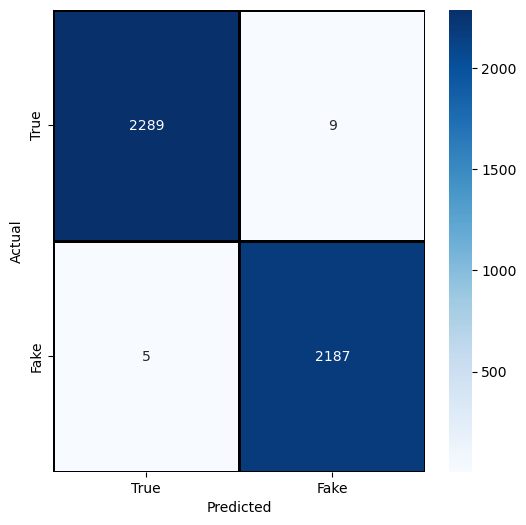

In [205]:
plt.figure(figsize = (6,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['True','Fake'] , yticklabels = ['True','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [215]:
from sklearn.metrics import classification_report
print(classification_report(y_test_lst, y_pred, target_names = ['Predicted Fake','Predicted True']))

                precision    recall  f1-score   support

Predicted Fake       1.00      1.00      1.00      2294
Predicted True       1.00      1.00      1.00      2196

      accuracy                           1.00      4490
     macro avg       1.00      1.00      1.00      4490
  weighted avg       1.00      1.00      1.00      4490



### pred

In [207]:
def preprocess_text(text, TEXT):
    tokenized = TEXT.tokenize(text)
    idx = [TEXT.vocab.stoi[token] for token in tokenized]
    tensor = torch.LongTensor(idx).unsqueeze(1)
    return tensor

In [208]:
preprocess_text("Donald Trump is thirty years old",TEXT=TEXT)

tensor([[    0],
        [    0],
        [   13],
        [11726],
        [  119],
        [  740]])

In [216]:
model.eval()
o1 = model()

RNN_LSTM(
  (embedding_layer): Embedding(46287, 100)
  (lstm): LSTM(100, 256, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)